In [ ]:
!pip -q install -U hyperopt scikit-learn pandas matplotlib

import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss

X, y = load_breast_cancer(return_X_y=True)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
space = hp.choice("model_family", [
    {
        "model": "logreg",
        "scaler": True,
        "C": hp.loguniform("lr_C", np.log(1e-4), np.log(1e2)),
        "penalty": hp.choice("lr_penalty", ["l2"]),
        "solver": hp.choice("lr_solver", ["lbfgs", "liblinear"]),
        "max_iter": scope.int(hp.quniform("lr_max_iter", 200, 2000, 50)),
        "class_weight": hp.choice("lr_class_weight", [None, "balanced"]),
    },
    {
        "model": "svm",
        "scaler": True,
        "kernel": hp.choice("svm_kernel", ["rbf", "poly"]),
        "C": hp.loguniform("svm_C", np.log(1e-4), np.log(1e2)),
        "gamma": hp.loguniform("svm_gamma", np.log(1e-6), np.log(1e0)),
        "degree": scope.int(hp.quniform("svm_degree", 2, 5, 1)),
        "class_weight": hp.choice("svm_class_weight", [None, "balanced"]),
    }
])

In [ ]:
def build_pipeline(params: dict) -> Pipeline:
    steps = []
    if params.get("scaler", True):
        steps.append(("scaler", StandardScaler()))

    if params["model"] == "logreg":
        clf = LogisticRegression(
            C=float(params["C"]),
            penalty=params["penalty"],
            solver=params["solver"],
            max_iter=int(params["max_iter"]),
            class_weight=params["class_weight"],
            n_jobs=None,
        )
    elif params["model"] == "svm":
        kernel = params["kernel"]
        clf = SVC(
            kernel=kernel,
            C=float(params["C"]),
            gamma=float(params["gamma"]),
            degree=int(params["degree"]) if kernel == "poly" else 3,
            class_weight=params["class_weight"],
            probability=True,
        )
    else:
        raise ValueError(f"Unknown model type: {params['model']}")

    steps.append(("clf", clf))
    return Pipeline(steps)

def objective(params: dict):
    t0 = time.time()
    try:
        pipe = build_pipeline(params)
        scores = cross_val_score(
            pipe,
            X, y,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1,
            error_score="raise",
        )
        mean_auc = float(np.mean(scores))
        std_auc = float(np.std(scores))
        loss = 1.0 - mean_auc
        elapsed = float(time.time() - t0)

        return {
            "loss": loss,
            "status": STATUS_OK,
            "attachments": {
                "mean_auc": mean_auc,
                "std_auc": std_auc,
                "elapsed_sec": elapsed,
            },
        }
    except Exception as e:
        elapsed = float(time.time() - t0)
        return {
            "loss": 1.0,
            "status": STATUS_FAIL,
            "attachments": {
                "error": repr(e),
                "elapsed_sec": elapsed,
            },
        }

In [ ]:
trials = Trials()

rstate = np.random.default_rng(123)
max_evals = 80

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    rstate=rstate,
    early_stop_fn=no_progress_loss(20),
)

print("\nRaw `best` (note: includes choice indices):")
print(best)

In [ ]:
def decode_best(space, best):
    from hyperopt.pyll.stochastic import sample
    fake = {}
    def _fill(node):
        return node
    cfg = sample(space, rng=np.random.default_rng(0))
    return None

best_trial = trials.best_trial
best_params = best_trial["result"].get("attachments", {}).copy()

best_used_params = best_trial["misc"]["vals"].copy()
best_used_params = {k: (v[0] if isinstance(v, list) and len(v) else v) for k, v in best_used_params.items()}

MODEL_FAMILY = ["logreg", "svm"]
LR_PENALTY = ["l2"]
LR_SOLVER = ["lbfgs", "liblinear"]
LR_CLASS_WEIGHT = [None, "balanced"]
SVM_KERNEL = ["rbf", "poly"]
SVM_CLASS_WEIGHT = [None, "balanced"]

mf = int(best_used_params.get("model_family", 0))
decoded = {"model": MODEL_FAMILY[mf]}

if decoded["model"] == "logreg":
    decoded.update({
        "C": float(best_used_params["lr_C"]),
        "penalty": LR_PENALTY[int(best_used_params["lr_penalty"])],
        "solver": LR_SOLVER[int(best_used_params["lr_solver"])],
        "max_iter": int(best_used_params["lr_max_iter"]),
        "class_weight": LR_CLASS_WEIGHT[int(best_used_params["lr_class_weight"])],
        "scaler": True,
    })
else:
    decoded.update({
        "kernel": SVM_KERNEL[int(best_used_params["svm_kernel"])],
        "C": float(best_used_params["svm_C"]),
        "gamma": float(best_used_params["svm_gamma"]),
        "degree": int(best_used_params["svm_degree"]),
        "class_weight": SVM_CLASS_WEIGHT[int(best_used_params["svm_class_weight"])],
        "scaler": True,
    })

print("\nDecoded best configuration:")
print(decoded)

print("\nBest trial metrics:")
print(best_params)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 83.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.1 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.1 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.1 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.1 which is incompatible.
 50%|█████     | 40/80 [00:07<00:07,  5.18trial/s, best los

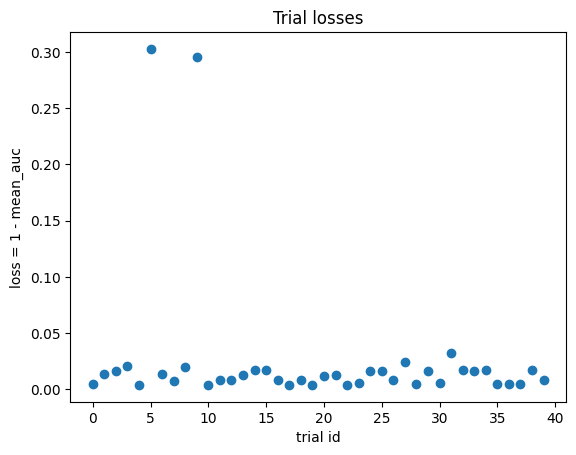

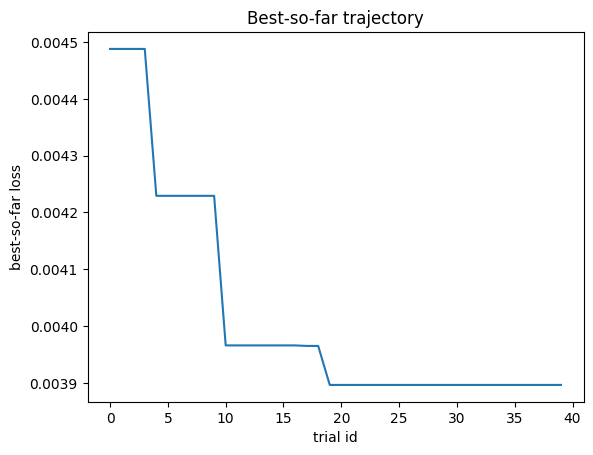


Final model fitted on full dataset.
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=24.966096521248776, class_weight='balanced',
                     gamma=0.009250670374706036, probability=True))])

NOTE: SparkTrials is primarily useful on Spark/Databricks environments.
Hyperopt SparkTrials docs exist, but Colab is typically not the right place for it.


In [1]:
rows = []
for t in trials.trials:
    res = t.get("result", {})
    att = res.get("attachments", {}) if isinstance(res, dict) else {}
    status = res.get("status", None) if isinstance(res, dict) else None
    loss = res.get("loss", None) if isinstance(res, dict) else None

    vals = t.get("misc", {}).get("vals", {})
    vals = {k: (v[0] if isinstance(v, list) and len(v) else None) for k, v in vals.items()}

    rows.append({
        "tid": t.get("tid"),
        "status": status,
        "loss": loss,
        "mean_auc": att.get("mean_auc"),
        "std_auc": att.get("std_auc"),
        "elapsed_sec": att.get("elapsed_sec"),
        **{f"p_{k}": v for k, v in vals.items()},
    })

df = pd.DataFrame(rows).sort_values("tid").reset_index(drop=True)

print("\nTop 10 trials by best loss:")
print(df[df["status"] == STATUS_OK].sort_values("loss").head(10)[
    ["tid", "loss", "mean_auc", "std_auc", "elapsed_sec", "p_model_family"]
])

ok = df[df["status"] == STATUS_OK].copy()
ok["best_so_far"] = ok["loss"].cummin()

plt.figure()
plt.plot(ok["tid"], ok["loss"], marker="o", linestyle="none")
plt.xlabel("trial id")
plt.ylabel("loss = 1 - mean_auc")
plt.title("Trial losses")
plt.show()

plt.figure()
plt.plot(ok["tid"], ok["best_so_far"])
plt.xlabel("trial id")
plt.ylabel("best-so-far loss")
plt.title("Best-so-far trajectory")
plt.show()

final_pipe = build_pipeline(decoded)
final_pipe.fit(X, y)

print("\nFinal model fitted on full dataset.")
print(final_pipe)

print("\nNOTE: SparkTrials is primarily useful on Spark/Databricks environments.")
print("Hyperopt SparkTrials docs exist, but Colab is typically not the right place for it.")